# Gas Price Predictions
by Jacob Ash and Zachary Greenberg

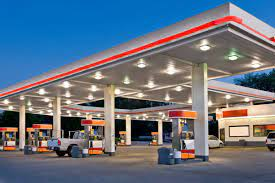

# Overview

The price of gasoline changes over time. Since 1995, there has been an 88% increase. Of course, the rate of increase ebbs and flows periodically. Understanding these patterns will give us the power of prediction. This power can influence financial decisions based on travel. We seek to identify and capture these useful patterns in the data to accurately make predictions. We have created various timeseries models from ARIMA to SARIMAX to Facebook Prophet to help gain insight on the gas price market of the near future. By utilizing the RMSE as an evaluation of our models, we can choose the best one for the job.

# Business Problem

Gas prices directly affect drivers everywhere. The rise of gas prices will financially impact their decisions and budgetary allowances, possibly restricting travel. With the ability to estimate future pricing, this could give  transportation companies information so that they can plan ahead for their upcoming fiscal year. We intend to help them out by forecasting a year ahead.

# Data Understanding

Our data was combined and collected from multiple sources including the EIA Open Data API, Federal Reserve Economic Data, and Matteo Iacovello's Geopolitical Risk Index dataset. Our target variable is retail gas prices in US dollars. 

In [1]:
#importing necessary libraries
import pandas as pd
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 400)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima 
from pmdarima import model_selection
from pmdarima.arima import ARIMA

from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading in the data
oil_prices = pd.read_csv('Data/OilPrices.csv')

#checking the rows & columns of the data
oil_prices.shape

(578, 32)

In [3]:
#checking the first 5 rows
oil_prices.head()

,date,retail_gas_price,regular_gas_price,premium_gas_price,europe_brent,wti,oil_supply,crude_oil_production,employees_oil_extraction,imports,federal_gas_tax,state_gas_tax,inflation,GPR_TURKEY,GPR_MEXICO,GPR_KOREA,GPR_RUSSIA,GPR_INDIA,GPR_BRAZIL,GPR_CHINA,GPR_INDONESIA,GPR_SAUDI_ARABIA,GPR_SOUTH_AFRICA,GPR_ARGENTINA,GPR_COLOMBIA,GPR_VENEZUELA,GPR_THAILAND,GPR_UKRAINE,GPR_ISRAEL,GPR_MALAYSIA,GPR_PHILIPPINES,GPR_HONG_KONG
0,1973-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,8981.323,136.3,6.256,4.124,8.275,6.17776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1973-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,9178.750,136.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1973-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,9098.194,136.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1973-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,9095.200,135.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1973-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,9062.548,135.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Because of the vast majority of NaN values here, we will condense the DataFrame to the available values.

In [4]:
#checking the dtypes
oil_prices.dtypes.head()

date                  object
retail_gas_price     float64
regular_gas_price    float64
premium_gas_price    float64
europe_brent         float64
dtype: object

In [5]:
#checking the descriptive statistics
oil_prices.describe()

,retail_gas_price,regular_gas_price,premium_gas_price,europe_brent,wti,oil_supply,crude_oil_production,employees_oil_extraction,imports,federal_gas_tax,state_gas_tax,inflation,GPR_TURKEY,GPR_MEXICO,GPR_KOREA,GPR_RUSSIA,GPR_INDIA,GPR_BRAZIL,GPR_CHINA,GPR_INDONESIA,GPR_SAUDI_ARABIA,GPR_SOUTH_AFRICA,GPR_ARGENTINA,GPR_COLOMBIA,GPR_VENEZUELA,GPR_THAILAND,GPR_UKRAINE,GPR_ISRAEL,GPR_MALAYSIA,GPR_PHILIPPINES,GPR_HONG_KONG
count,518.000000,364.000000,315.000000,406.000000,422.000000,481.000000,578.000000,578.000000,48.000000,47.000000,44.000000,47.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,1.831703,2.070173,2.517546,46.446305,44.090735,12243.977131,6510.779481,170.615052,9.161771,16.432085,24.586727,3.967960,111.459363,99.425612,108.552444,106.157076,93.797929,104.037631,106.273965,73.921822,92.811139,111.246845,111.025338,79.264288,85.936609,94.582728,128.577031,84.094340,89.687374,98.772223,103.192628
std,0.882518,0.879257,0.910967,32.212641,28.735599,6901.931759,1863.189391,38.610005,2.463364,8.543650,11.859635,2.976733,43.204881,25.863020,38.467790,28.932982,27.779754,29.848090,30.028329,31.879336,33.168800,46.124477,43.701844,28.850587,38.497569,38.837927,64.432099,22.828057,35.027091,35.202383,43.609107
min,0.629000,0.921000,1.112000,9.820000,11.350000,-6454.000000,3292.526000,118.400000,5.051000,3.953000,8.132000,-0.355546,32.630966,55.027180,38.703595,47.675739,48.592841,43.022946,56.530560,20.195272,33.177399,36.626554,36.401680,22.781653,16.383513,35.438023,22.178185,45.782138,17.493473,35.246466,41.055417
25%,1.185250,1.199750,1.614500,18.792500,19.815000,7296.000000,4947.443750,141.550000,7.379750,8.891000,12.582500,2.159069,82.172208,80.657549,83.110333,86.107217,77.231851,84.635982,86.758396,51.272778,67.041119,78.380801,81.591078,58.411975,58.712477,68.791618,81.055858,67.727024,66.931549,72.830272,75.984658
50%,1.353500,2.043500,2.685000,32.920000,31.975000,11650.000000,6075.096500,161.250000,9.068500,19.647000,25.431000,3.028820,102.466897,93.516162,101.524757,100.772778,86.619624,100.435857,98.512790,67.993152,87.333268,100.337905,103.911472,76.751229,81.787949,86.356645,110.670476,80.124521,83.607677,92.147624,94.100410
75%,2.510500,2.730500,3.204500,65.845000,62.252500,16434.000000,7606.091000,192.600000,10.998000,23.734000,35.427500,4.563769,133.026432,112.810135,124.774410,118.516517,103.252657,117.011294,121.004825,89.466255,113.352947,137.424993,132.767482,95.960363,107.301771,109.548548,170.865361,94.399759,105.816729,120.120184,114.671167
max,4.142000,4.062000,4.298000,132.720000,133.880000,33290.000000,12375.669000,267.000000,13.714000,26.741000,43.845000,13.549202,320.257923,215.507676,274.424333,241.381421,246.561895,221.406770,253.398709,275.937988,210.636587,301.707870,371.011584,171.849735,233.484231,296.192780,382.865514,179.204698,278.881456,215.536887,373.784359


# Data Preparation

In [6]:
#changing the date column to datetime and setting it as the index
oil_prices['date'] = pd.to_datetime(oil_prices['date'])
oil_prices.set_index('date', inplace = True)

The data has 31 columns now that we have set the datetime index. Employees and import data go all the way back to 1973. The other columns start to appear around 1995. We will make '95 our starting point and go all the way until 2020 giving us a total of 25 years of data to analyze.

In [7]:
#modifying the dataframe in place
oil_prices = oil_prices.loc['1995-01':'2020-12']

For the GPR data that we collected, we decided to filter it and keep ONLY the countries that are in top 5 sources of US oil & petroleum imports according to the eia:

https://www.eia.gov/energyexplained/oil-and-petroleum-products/imports-and-exports.php#:~:text=Of%20the%2013%20members%20of,and%20the%20United%20Arab%20Emirates

In [8]:
#removing unnecessary columns
columns_to_remove = ['regular_gas_price', 'premium_gas_price', 'GPR_TURKEY', 'GPR_KOREA', 'GPR_INDIA', 'GPR_BRAZIL', 'GPR_CHINA', 'GPR_INDONESIA', 
                     'GPR_SOUTH_AFRICA', 'GPR_ARGENTINA', 'GPR_VENEZUELA', 'GPR_THAILAND', 'GPR_UKRAINE', 
                     'GPR_ISRAEL', 'GPR_MALAYSIA', 'GPR_PHILIPPINES', 'GPR_HONG_KONG']

for i in columns_to_remove:
    del oil_prices[i]

In [9]:
#checking out the new dataframe
oil_prices.tail()

,retail_gas_price,europe_brent,wti,oil_supply,crude_oil_production,employees_oil_extraction,imports,federal_gas_tax,state_gas_tax,inflation,GPR_MEXICO,GPR_RUSSIA,GPR_SAUDI_ARABIA,GPR_COLOMBIA
date,,,,,,,,,,,,,,
2020-08-01,2.245,44.74,42.34,26591.0,10140.248,134.8,NaN,NaN,NaN,NaN,109.629507,123.228968,75.137051,35.187865
2020-09-01,2.260,40.91,39.63,9893.0,10428.743,136.6,NaN,NaN,NaN,NaN,130.238082,132.721661,69.758375,48.769146
2020-10-01,2.228,40.19,39.40,18756.0,9979.372,137.7,NaN,NaN,NaN,NaN,143.638311,141.334089,74.266738,23.759327
2020-11-01,2.159,42.69,40.94,14949.0,10657.049,139.4,NaN,NaN,NaN,NaN,120.577633,114.384703,65.022448,49.863902
2020-12-01,2.235,49.99,47.02,12226.0,10600.133,139.5,NaN,NaN,NaN,NaN,104.729149,106.944362,97.054702,37.178948


In [10]:
#looking at our new shape
oil_prices.shape

(312, 14)

In [11]:
#looking for other missing values
oil_prices.isna().sum()

retail_gas_price              0
europe_brent                  0
wti                           0
oil_supply                    0
crude_oil_production          0
employees_oil_extraction      0
imports                     286
federal_gas_tax             287
state_gas_tax               290
inflation                   287
GPR_MEXICO                    0
GPR_RUSSIA                    0
GPR_SAUDI_ARABIA              0
GPR_COLOMBIA                  0
dtype: int64

The columns with the missing values here are because they are annual data. To fill these NAs we are going utilize forward filling to create monthly data to match the rest of the variables.

In [12]:
def forward_fill(x):
    '''
    This function performs forward filling on 
    columns with NA values
    '''
    x = x.ffill()
    return x

In [13]:
#list of columns to fill
to_forward_fill = list(oil_prices.columns[-8:-4])

#filling in our null values
for i in to_forward_fill:
    oil_prices[i] = forward_fill(oil_prices[i])

In [14]:
oil_prices.head()

,retail_gas_price,europe_brent,wti,oil_supply,crude_oil_production,employees_oil_extraction,imports,federal_gas_tax,state_gas_tax,inflation,GPR_MEXICO,GPR_RUSSIA,GPR_SAUDI_ARABIA,GPR_COLOMBIA
date,,,,,,,,,,,,,,
1995-01-01,1.190,16.55,18.04,19008.0,5107.387,156.3,8.835,21.186,25.688,2.80542,83.757850,122.373827,67.086653,58.855041
1995-02-01,1.181,17.11,18.57,12266.0,5216.668,154.8,8.835,21.186,25.688,2.80542,121.314962,91.141319,74.670361,84.545052
1995-03-01,1.173,17.01,18.54,4377.0,5075.816,153.8,8.835,21.186,25.688,2.80542,97.815875,85.007412,65.955071,56.560819
1995-04-01,1.197,18.65,19.90,16790.0,5092.582,153.2,8.835,21.186,25.688,2.80542,99.019248,92.336931,50.134217,46.908018
1995-05-01,1.256,18.35,19.74,18790.0,5111.542,152.5,8.835,21.186,25.688,2.80542,68.559169,123.447355,69.894931,46.704323


In [15]:
oil_prices.isna().sum()

retail_gas_price            0
europe_brent                0
wti                         0
oil_supply                  0
crude_oil_production        0
employees_oil_extraction    0
imports                     0
federal_gas_tax             0
state_gas_tax               0
inflation                   0
GPR_MEXICO                  0
GPR_RUSSIA                  0
GPR_SAUDI_ARABIA            0
GPR_COLOMBIA                0
dtype: int64

Our data is now fully filled out. We can start to do some EDA.

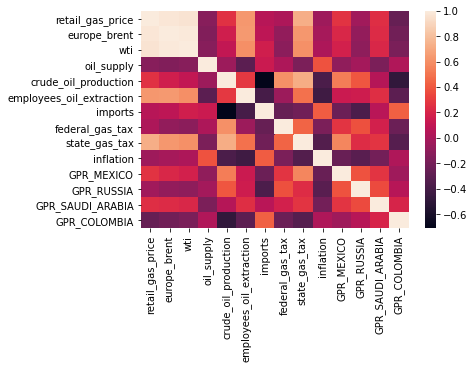

In [16]:
sns.heatmap(oil_prices.corr());

Although the correlation between gas prices is high with both europe_brent and wti, we decided to keep them in our model as they are the 2 factors that will most likely help us without goal.

# Exploratory Data Analysis

First we'll take a look at our target variable

**Distribution of Gas Prices**

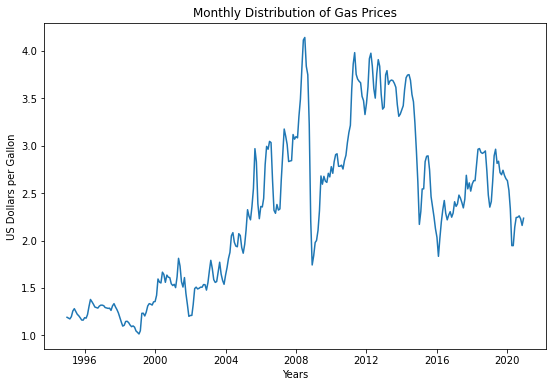

In [17]:
#creating a distribution of gas prices, the target variable
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(oil_prices['retail_gas_price'])
ax.set_ylabel('US Dollars per Gallon')
ax.set_xlabel('Years')
ax.set_title('Monthly Distribution of Gas Prices');

In general, there seems to be an increasing trend in gas prices over the past 25 years. There are, however, two major dips in our data.  We have determined they were due to the economy crash in 2008, and the overproduction of crude oil from Saudi Arabia in 2014.

Now let's look at some of our exogenous variables:

**Distribution of Benchmark Oil Prices**

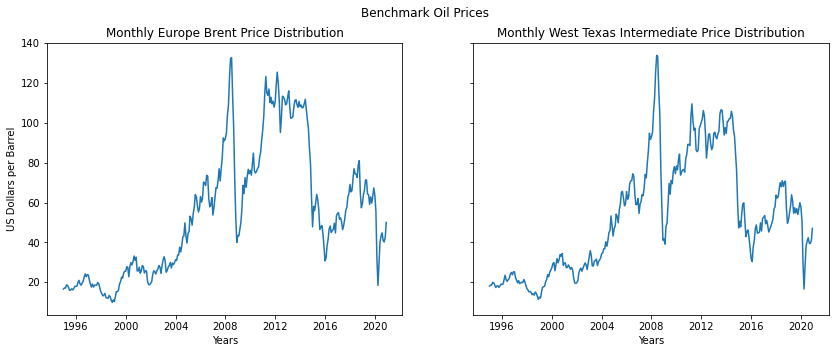

In [18]:
#creating graphs for the 2 main benchmark oil prices
fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,5))
ax[0].plot(oil_prices['europe_brent'])
ax[1].plot(oil_prices['wti'])
ax[0].set_ylabel('US Dollars per Barrel')
ax[0].set_xlabel('Years')
ax[1].set_xlabel('Years')
ax[0].set_title('Monthly Europe Brent Price Distribution')
ax[1].set_title('Monthly West Texas Intermediate Price Distribution')
plt.suptitle('Benchmark Oil Prices');


These two oil markets, Brent being from the North Sea and WTI originating from the US shale fields are benchmark prices for the crude oil market. We can see here that they ebb and flow together, and that they also mimic the distribution of retail gas prices.

**Distribution of Oil Supply, Production, and Imports**

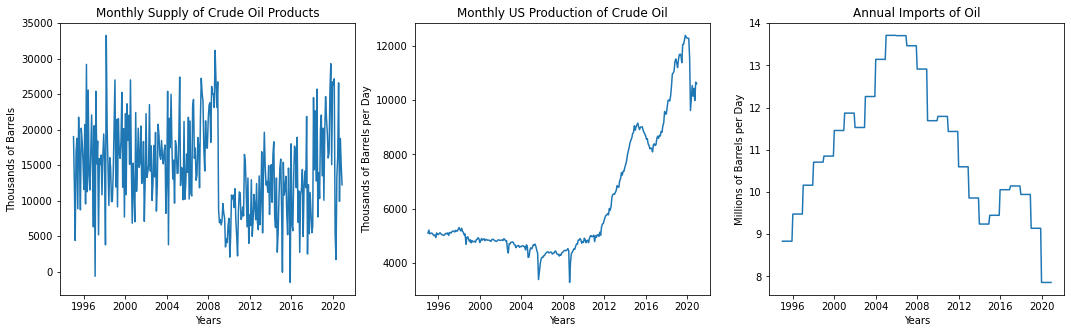

In [19]:
#creating graphs for the distribution of oil supply, production, and imports
fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].plot(oil_prices['oil_supply'])
ax[1].plot(oil_prices['crude_oil_production'])
ax[2].plot(oil_prices['imports'])
ax[0].set_ylabel('Thousands of Barrels')
ax[1].set_ylabel('Thousands of Barrels per Day')
ax[2].set_ylabel('Millions of Barrels per Day')
ax[0].set_xlabel('Years')
ax[1].set_xlabel('Years')
ax[2].set_xlabel('Years')
ax[0].set_title('Monthly Supply of Crude Oil Products')
ax[1].set_title('Monthly US Production of Crude Oil')
ax[2].set_title('Annual Imports of Oil');

The shape of the Crude Oil Supply mimics the shape of our other graphs. The US Production of Crude oil has increased almost exponentially throughout the years. As we look at the annual imports, with the decline of imports, we believe this is due to the increase of US production, therefore decreasing the need for imports.

After some thought, we decided to drop the Employee Oil Extraction column as 

**Taxes and Inflation Rate Distribution**

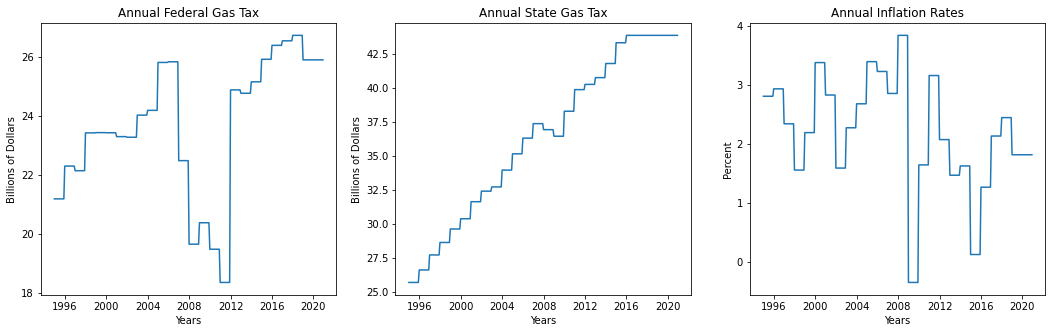

In [20]:
#creating graphs for gas taxes and inflation rates
fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].plot(oil_prices['federal_gas_tax'])
ax[1].plot(oil_prices['state_gas_tax'])
ax[2].plot(oil_prices['inflation'])
ax[0].set_ylabel('Billions of Dollars')
ax[1].set_ylabel('Billions of Dollars')
ax[2].set_ylabel('Percent')
ax[0].set_xlabel('Years')
ax[1].set_xlabel('Years')
ax[2].set_xlabel('Years')
ax[0].set_title('Annual Federal Gas Tax')
ax[1].set_title('Annual State Gas Tax')
ax[2].set_title('Annual Inflation Rates');

**GPR Index Distribution**

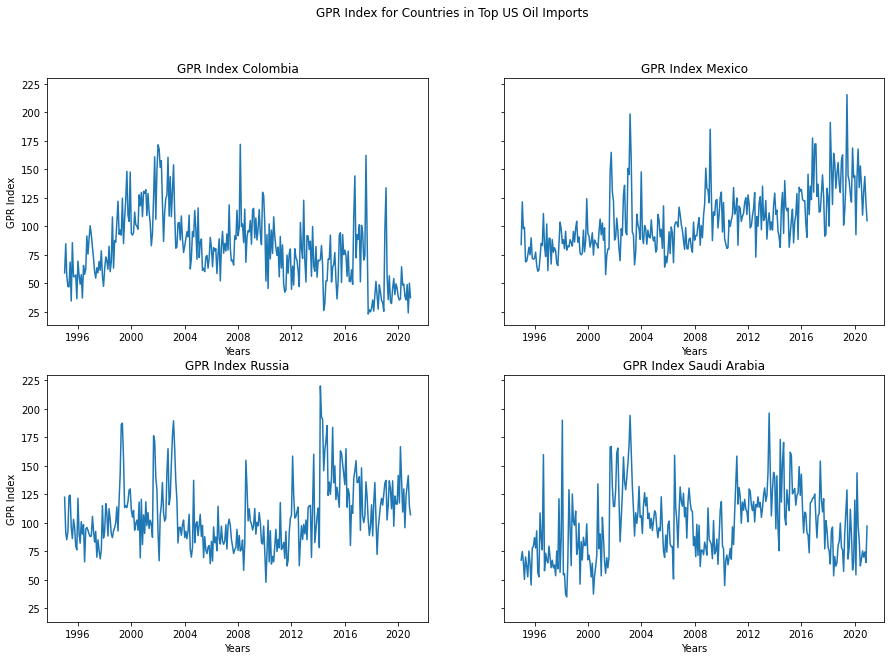

In [21]:
#creating 4 graphs of GPR Index for the countries in the top US oil imports
fig, ax = plt.subplots(2,2, sharey = True, figsize=(15,10))
ax[0,0].plot(oil_prices['GPR_COLOMBIA'])
ax[0,0].set_xlabel('Years')
ax[0,0].set_title('GPR Index Colombia')
ax[0,0].set_ylabel('GPR Index')
ax[0,1].plot(oil_prices['GPR_MEXICO'])
ax[0,1].set_title('GPR Index Mexico')
ax[0,1].set_xlabel('Years')
ax[1,0].plot(oil_prices['GPR_RUSSIA'])
ax[1,0].set_xlabel('Years')
ax[1,0].set_title('GPR Index Russia')
ax[1,0].set_ylabel('GPR Index')
ax[1,1].plot(oil_prices['GPR_SAUDI_ARABIA'])
ax[1,1].set_xlabel('Years')
ax[1,1].set_title('GPR Index Saudi Arabia')
plt.suptitle('GPR Index for Countries in Top US Oil Imports');

The GPR index has a scale up to 600.

# Searching For Trends

For our first set of models, we are going to utilize only the target variable along with the date.

In [22]:
#creating the dataframe for our first models
ts = oil_prices['retail_gas_price'].to_frame()
ts.head()

,retail_gas_price
date,
1995-01-01,1.190
1995-02-01,1.181
1995-03-01,1.173
1995-04-01,1.197
1995-05-01,1.256


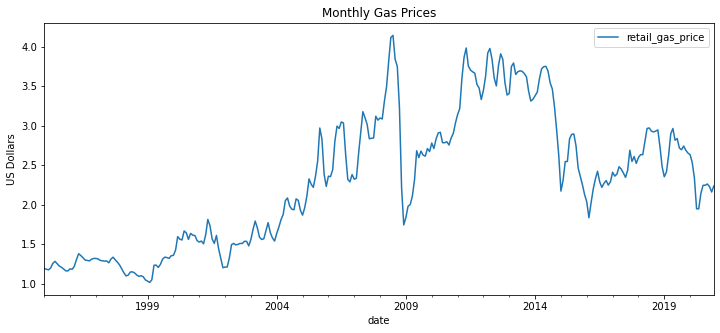

In [23]:
#plotting our data
title='Monthly Gas Prices'
ylabel='US Dollars'

ax = ts.plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set_ylabel(ylabel);

Our data is not stationary, we will now make an attempt to stationarize it so we can proceed with our timeseries.

In [24]:
def decompose(timeseries):
    """
    This function takes a timeseries
    and performs a seasonal decompose
    """
    result = seasonal_decompose(timeseries, model='add')
    result.plot();

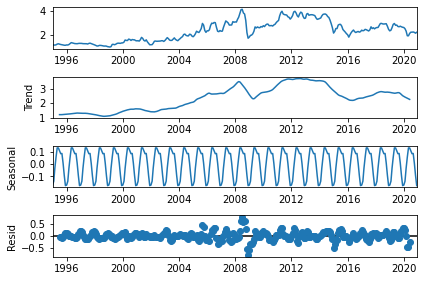

In [25]:
decompose(ts)

It looks like we have some seasonality in the data. Our research shows that this could be because of the rising demand for oil in the summer months as people do more driving.

In [26]:
def stationarity_test(timeseries, season):
    """
    This function takes a timeseries & season and creates
    a graph with the rolling mean and standard deviation, 
    and additionally calculates the Augmented Dickey Fuller 
    test's p-value.
    """
    #calculating the rolling mean
    rolmean = timeseries.rolling(season).mean()
    #calculating the rolling std
    rolstd = timeseries.rolling(season).std()

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.ylabel('Gas Price in US Dollars')
    plt.xlabel('Month')
    plt.title('Monthly Distribution of Gas Prices')
    plt.show()

    print(f'Augmented Dickey Fuller p-value: {adfuller(timeseries)[1]}')

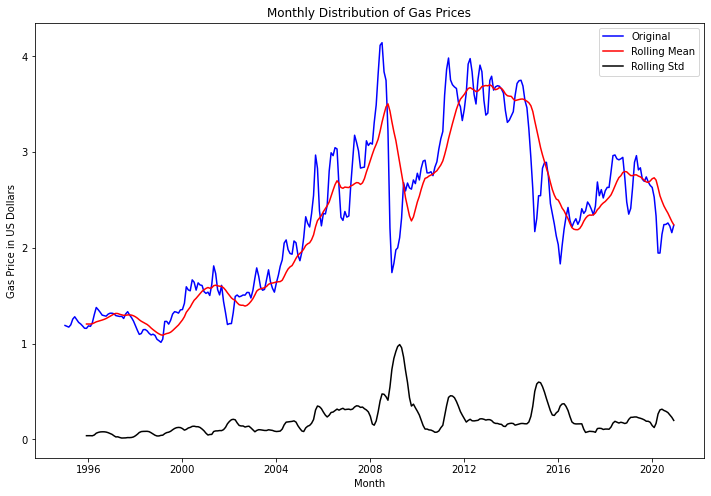

Augmented Dickey Fuller p-value: 0.448167594922904


In [27]:
stationarity_test(ts, 12)

This pvalue for the Augmented Dickey Fuller test tells us that our data is not stationary. We will now take a first difference to get a lower pvalue.

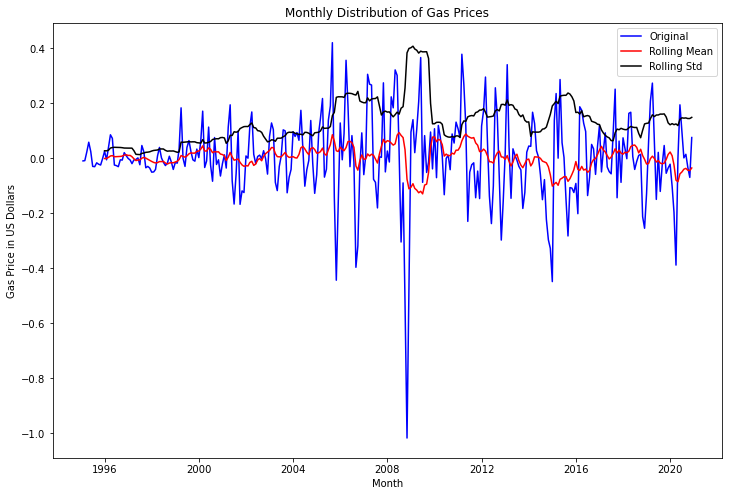

Augmented Dickey Fuller p-value: 1.614616710411381e-08


In [28]:
#first difference
ts_diff = ts.diff().dropna()

stationarity_test(ts_diff, 12)

The p-value result is lower, however, we did notice a seasonal trend from above, we will address this issue by taking a seasonal difference.

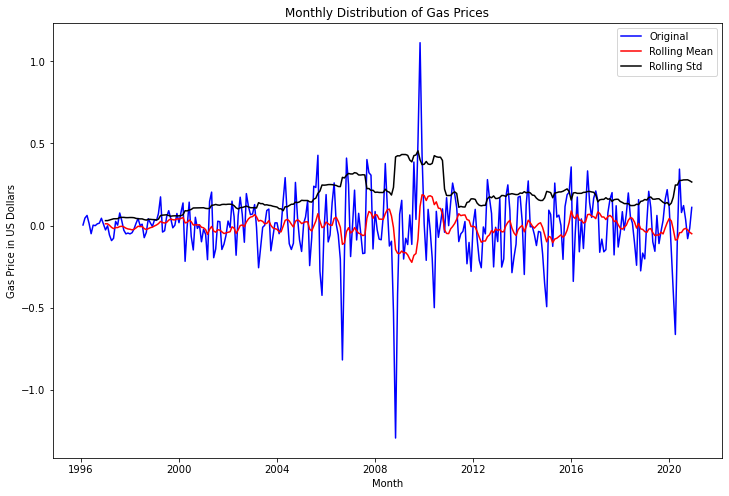

Augmented Dickey Fuller p-value: 1.3950080267875783e-07


In [29]:
#taking a seasonal difference of the first difference
ts_seasonal_diff = ts_diff.diff(12).dropna()

stationarity_test(ts_seasonal_diff, 12)

From taking the seasonal difference, our data appears more stable.

# Model Preparation

In [30]:
def train_test(dataframe):
    """
    This function splits the data into 
    train test split
    """
    #splitting the data into train/test
    cutoff = round(dataframe.shape[0]*0.98)


    train = dataframe[:cutoff] #everything up to the cutoff
    test = dataframe[cutoff:] #cutoff up
    return train, test, cutoff

In [31]:
train, test, cutoff = train_test(ts)

In [32]:
len(train)

306

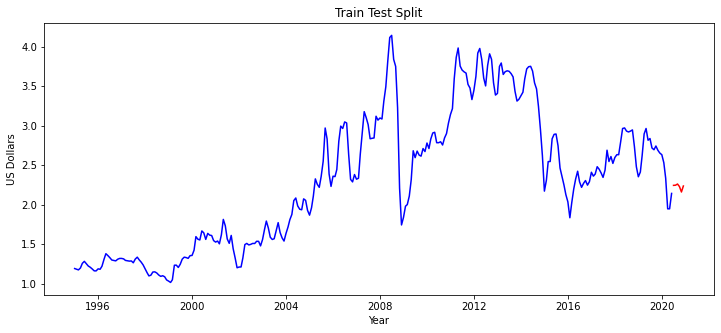

In [33]:
#plotting the train and test split of our data
fig, ax = plt.subplots(figsize=(12,5))
plot_train = ax.plot(train, color='blue')
plot_test = ax.plot(test, color='red')
ax.set_xlabel('Year')
ax.set_ylabel('US Dollars')
ax.set_title('Train Test Split');

In [34]:
def acf_pcf(timeseries, lag):
    """
    This function takes in a timeseries and the desired lag,
    it outputs side by side ACF PACF graphs.
    """
    fig, axes = plt.subplots(1, 2, figsize=(17, 5))
    fig.suptitle('ACF & PACF')

    sm.graphics.tsa.plot_acf(timeseries.iloc[1:], lags=lag, ax=axes[0])

    sm.graphics.tsa.plot_pacf(timeseries.iloc[1:], lags=lag, ax=axes[1])
    plt.tight_layout()

From the Dickey Fuller Test above, we realized we needed to take a seasonal first difference and a first difference to stationarize our data. We will use this to evalue the AR and MA parameters for our future models.

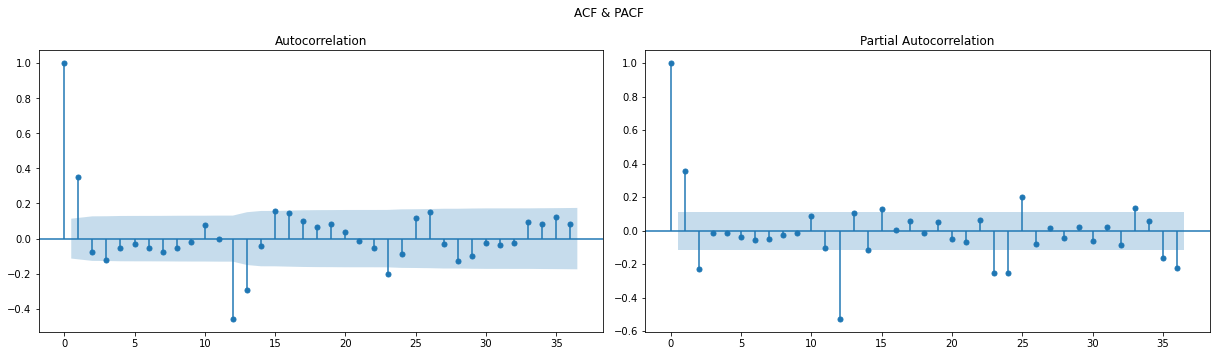

In [35]:
acf_pcf(ts.diff().diff(12).dropna(), 36)

For our model, the PAC and ACF results suggest an AR of 2 and an MA of 1.

# Modeling

## ARIMA Model

In [36]:
#importing ARIMA
from statsmodels.tsa.arima.model import ARIMA

ar = ARIMA(train, order=(2, 1, 1)).fit()

In [37]:
# #importing cross validaton
# from sklearn.model_selection import cross_val_score


# #getting the cross val recall score
# ar = cross_val_score(ar, train, scoring = 'mean_squared_error', cv = 3)
# print(ar)

In [38]:
# cv = model_selection.RollingForecastCV(step=1, h=12)
# ar_cv_scores = model_selection.cross_val_score(ar, train, scoring='mean_squared_error', cv = cv )

In [39]:
train_yhat_ar = ar.predict(typ='levels', dynamic=False)
train_yhat_ar[-5:]

2020-02-01    2.632070
2020-03-01    2.492406
2020-04-01    2.261630
2020-05-01    1.802275
2020-06-01    2.036807
Freq: MS, Name: predicted_mean, dtype: float64

In [40]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       retail_gas_price   No. Observations:                  306
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 194.690
Date:                Wed, 21 Apr 2021   AIC                           -381.380
Time:                        14:06:56   BIC                           -366.499
Sample:                    01-01-1995   HQIC                          -375.428
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2680      0.063     20.042      0.000       1.144       1.392
ar.L2         -0.5225      0.041    -12.600      0.000      -0.604      -0.441
ma.L1         -0.7789      0.069    -11.337      0.000      -0.914      -0.644
sigma2         0.0163      0.001     16.165      0.000       0.014       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               262.61
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               4.56   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
#RMSE Value
artrain_rmse = np.sqrt(mean_squared_error(train, train_yhat_ar))
artrain_rmse

0.1444990702529214

The RMSE value is not bad for a first attempt at a model. Let's graph the predictions below:

In [42]:
def predictions_graph(predictions, data):
    """
    This function takes in the predictions and data (train or test) outputs
    2 graphs, 1 of the predictions, and 1 of the predictions zoomed in.
    """
    fig, axes = plt.subplots(figsize=(17, 5))
    
    labels=['Original', 'Prediction']
    
    axes.plot(data)
    axes.set_ylabel('US Dollars')
    axes.set_xlabel('Year')
    axes.plot(predictions)
    axes.set_title('Predictions')
    axes.legend(labels)

    plt.tight_layout()

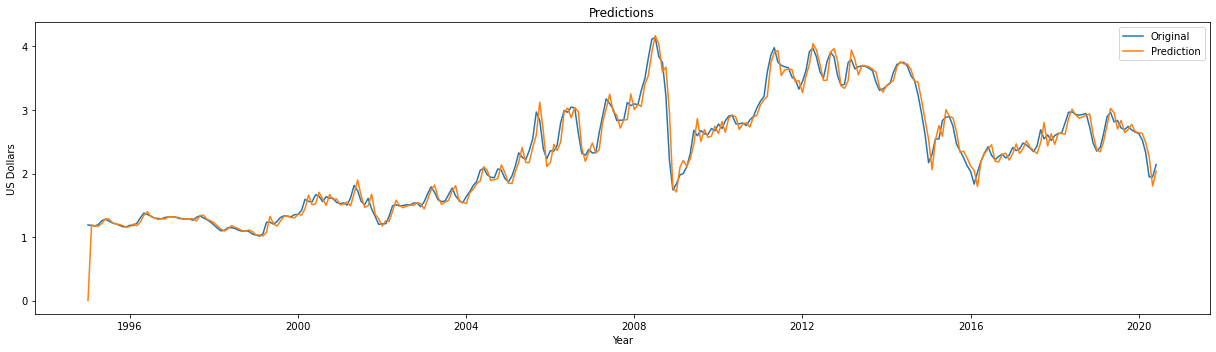

In [43]:
predictions_graph(train_yhat_ar, train)

The predictions on the train set seem to be doing pretty well. Now let's try out the predictions on the test set.

In [44]:
test.head()

,retail_gas_price
date,
2020-07-01,2.243
2020-08-01,2.245
2020-09-01,2.260
2020-10-01,2.228
2020-11-01,2.159


In [45]:
test_yhat_ar = ar.predict(start = test.index[0],end = test.index[-1],typ='levels')

In [46]:
#RMSE Value
artest_rmse = np.sqrt(mean_squared_error(test, test_yhat_ar))
artest_rmse

0.21043729264666344

There was a slight increase in the RMSE value, indicating a worse performance for the model's testing set.

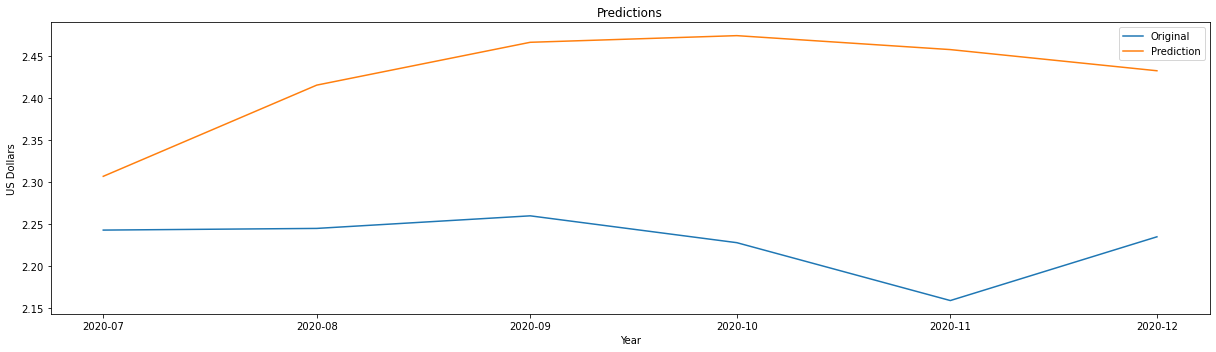

In [47]:
predictions_graph(test_yhat_ar, test)

The test set seems to be missing the mark. Perhaps a different kind of model would be better suited for our data.

## Sarima Model

In [48]:
#utilizing auto_arima to assess the ideal parameters
auto_arima(train, seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  306
Model:             SARIMAX(5, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 206.779
Date:                              Wed, 21 Apr 2021   AIC                           -391.558
Time:                                      14:07:43   BIC                           -350.634
Sample:                                           0   HQIC                          -375.189
                                              - 306                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1932      0.071     16.914      0.000       1.055       1.331
ar.L2          0.0766      0.102      0.748      0.454      -0.124       0.277
ar.L3         -1.0926      0.074    -14.760      0.000      -1.238      -0.948
ar.L4          0.6795      0.078      8.678      0.000       0.526       0.833
ar.L5         -0.3002      0.056     -5.399      0.000      -0.409      -0.191
ma.L1         -0.6716      0.048    -13.997      0.000      -0.766      -0.578
ma.L2         -0.7077      0.060    -11.756      0.000      -0.826      -0.590
ma.L3          0.9047      0.049     18.370      0.000       0.808       1.001
ar.S.L12       0.0426      0.360      0.118      0.906      -0.662       0.747
ma.S.L12      -0.2104      0.362     -0.581      0.561      -0.919       0.499
sigma2         0.0150      0.001     15.146      0.000       0.013       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               183.56
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               4.95   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

After running auto_arima it told us the ideal parameters for SARIMAX ((5,1,3)(1,0,1,12)), so we will create a model with those parameters in mind.

In [49]:
#importing SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

sr =SARIMAX(train,
                  order=(5, 1, 3),
                  seasonal_order=(1, 0, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

train_yhat_sr = sr.predict(typ='levels')
train_yhat_sr[:5]

1995-01-01    0.000000
1995-02-01    1.709088
1995-03-01    0.872955
1995-04-01    1.402899
1995-05-01    1.123136
Freq: MS, Name: predicted_mean, dtype: float64

In [50]:
sr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     retail_gas_price   No. Observations:                  306
Model:             SARIMAX(5, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 179.640
Date:                              Wed, 21 Apr 2021   AIC                           -337.279
Time:                                      14:07:44   BIC                           -296.987
Sample:                                  01-01-1995   HQIC                          -321.133
                                       - 06-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8724      0.277      3.145      0.002       0.329       1.416
ar.L2         -0.7012      0.414     -1.695      0.090      -1.512       0.110
ar.L3          0.6344      0.425      1.492      0.136      -0.199       1.468
ar.L4         -0.2890      0.234     -1.237      0.216      -0.747       0.169
ar.L5         -0.0627      0.102     -0.616      0.538      -0.262       0.137
ma.L1         -0.8646      0.393     -2.200      0.028      -1.635      -0.094
ma.L2          0.0664      0.418      0.159      0.874      -0.752       0.885
ma.L3         -0.8274      0.323     -2.562      0.010      -1.460      -0.194
ar.S.L12    -1.75e-05      1.418  -1.23e-05      1.000      -2.780       2.780
ma.S.L12      -0.0465      1.413     -0.033      0.974      -2.816       2.723
sigma2         0.0099      0.003      3.054      0.002       0.004       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               137.16
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.03   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
#RMSE Value
srtrain_rmse = np.sqrt(mean_squared_error(train, train_yhat_sr))
srtrain_rmse

0.1478443049981645

The RMSE value has performed slightly worse than the ARIMA model above.

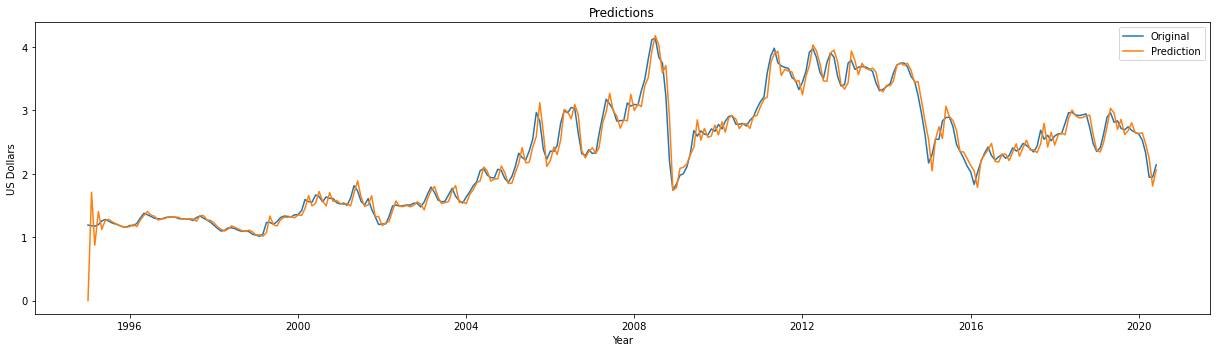

In [52]:
predictions_graph(train_yhat_sr, train)

We will now try the predictions on the test set.

In [53]:
test.head()

,retail_gas_price
date,
2020-07-01,2.243
2020-08-01,2.245
2020-09-01,2.260
2020-10-01,2.228
2020-11-01,2.159


In [54]:
test_yhat_sr = sr.predict(start = test.index[0],end = test.index[-1], dynamic= False)

In [55]:
#RMSE Value
srtest_rmse = np.sqrt(mean_squared_error(test, test_yhat_sr))
srtest_rmse

0.19662387989638813

The test set has befored slightly worse than the train. It is, however, an improvement from the ARIMA test set.

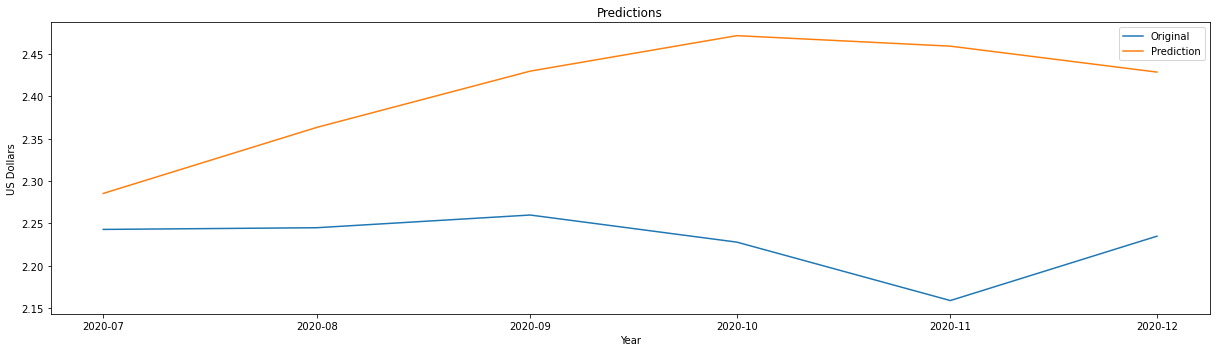

In [56]:
predictions_graph(test_yhat_sr, test)

The graph even looks a slight bit better. But perhaps we should try a third model.

## Facebook Prophet

In [96]:
test_fb

,ds,y
306,2020-07-01,2.243
307,2020-08-01,2.245
308,2020-09-01,2.260
309,2020-10-01,2.228
310,2020-11-01,2.159
311,2020-12-01,2.235


In [57]:
#importing Prophet for Facebook Prophet
from prophet import Prophet

In [58]:
#getting the dataframe for Prophet according to it's specifications
ts_for_fb = ts.reset_index()
ts_for_fb.rename(columns = {'date':'ds', 'retail_gas_price':'y'}, inplace = True)
ts_for_fb.head()

,ds,y
0,1995-01-01,1.190
1,1995-02-01,1.181
2,1995-03-01,1.173
3,1995-04-01,1.197
4,1995-05-01,1.256


In [99]:
#doing a train test split on the dataset

train_fb = ts_for_fb[:cutoff] #everything up to the cutoff
test_fb = ts_for_fb[cutoff:] #cutoff up

In [100]:
#instantiating and fitting the model
prophet_model = Prophet()
prophet_model.fit(train_fb);

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [101]:
train_yhat_fb = prophet_model.predict(train_fb)
train_yhat_fb[-5:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
301,2020-02-01,2.367437,1.714049,2.693072,2.367437,2.367437,-0.148037,-0.148037,-0.148037,-0.148037,-0.148037,-0.148037,0.0,0.0,0.0,2.219401
302,2020-03-01,2.356843,1.894776,2.867668,2.356843,2.356843,0.026841,0.026841,0.026841,0.026841,0.026841,0.026841,0.0,0.0,0.0,2.383684
303,2020-04-01,2.345518,1.927456,2.873323,2.345518,2.345518,0.043692,0.043692,0.043692,0.043692,0.043692,0.043692,0.0,0.0,0.0,2.389211
304,2020-05-01,2.334559,1.980284,2.917638,2.334559,2.334559,0.085678,0.085678,0.085678,0.085678,0.085678,0.085678,0.0,0.0,0.0,2.420237
305,2020-06-01,2.323234,2.001024,2.916833,2.323234,2.323234,0.126891,0.126891,0.126891,0.126891,0.126891,0.126891,0.0,0.0,0.0,2.450125


In [103]:
#RMSE Value
fbtrain_rmse = np.sqrt(mean_squared_error(train_fb['y'], train_yhat_fb['yhat']))
fbtrain_rmse

0.3659161055191558

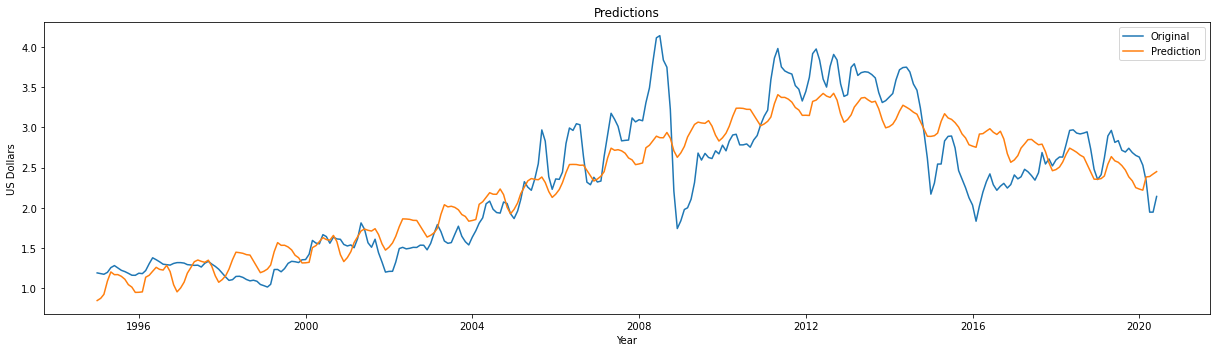

In [106]:
predictions_graph(train_yhat_fb.set_index('ds')['yhat'], train_fb.set_index('ds')['y'])


In [107]:
test_fb.head()

,ds,y
306,2020-07-01,2.243
307,2020-08-01,2.245
308,2020-09-01,2.260
309,2020-10-01,2.228
310,2020-11-01,2.159


In [108]:
test_yhat_fb = prophet_model.predict(test_fb)
test_yhat_fb[-5:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-08-01,2.300950,1.924386,2.839795,2.300950,2.300950,0.077953,0.077953,0.077953,0.077953,0.077953,0.077953,0.0,0.0,0.0,2.378903
2,2020-09-01,2.289625,1.938066,2.889947,2.289405,2.289865,0.129010,0.129010,0.129010,0.129010,0.129010,0.129010,0.0,0.0,0.0,2.418635
3,2020-10-01,2.278666,1.839942,2.789566,2.278029,2.279638,0.044148,0.044148,0.044148,0.044148,0.044148,0.044148,0.0,0.0,0.0,2.322814
4,2020-11-01,2.267341,1.688834,2.601722,2.266044,2.268905,-0.128236,-0.128236,-0.128236,-0.128236,-0.128236,-0.128236,0.0,0.0,0.0,2.139105
5,2020-12-01,2.256381,1.553905,2.500570,2.254322,2.258921,-0.223661,-0.223661,-0.223661,-0.223661,-0.223661,-0.223661,0.0,0.0,0.0,2.032720


In [110]:
#RMSE Value
fbtest_rmse = np.sqrt(mean_squared_error(test_fb['y'], test_yhat_fb['yhat']))
fbtest_rmse

0.14144590828872367

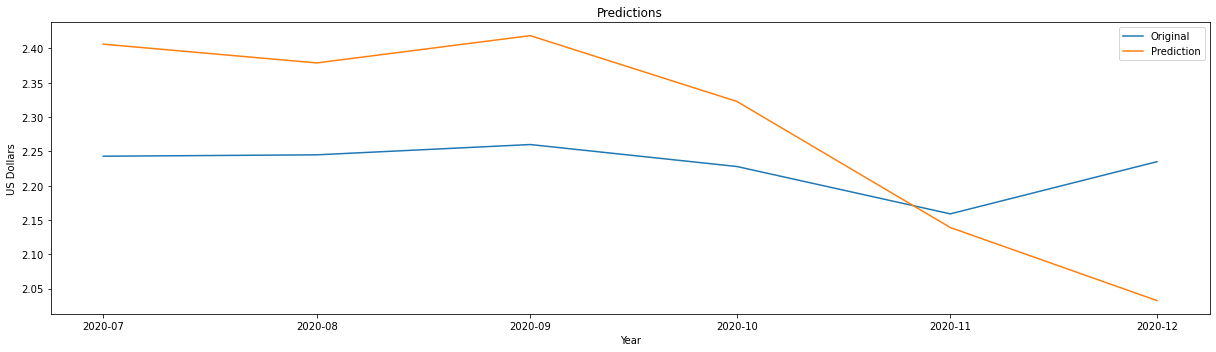

In [111]:
predictions_graph(test_yhat_fb.set_index('ds')['yhat'], test_fb.set_index('ds')['y'])

This model seems to capture the seasonality and the overall trend, however it doesn't seem to highlight the 2008 crash. 

The RMSE here is the highest we've seen. Perhaps it's time to add in our exogenous variables.

# Models with Exogenous Variables

In [64]:
#creating a list of exogenous columns
exog_list = list(oil_prices.columns[3:])

In [65]:
#compiling an exogenous dataframe
exog = oil_prices[exog_list]
exog.head()

,oil_supply,crude_oil_production,employees_oil_extraction,imports,federal_gas_tax,state_gas_tax,inflation,GPR_MEXICO,GPR_RUSSIA,GPR_SAUDI_ARABIA,GPR_COLOMBIA
date,,,,,,,,,,,
1995-01-01,19008.0,5107.387,156.3,8.835,21.186,25.688,2.80542,83.757850,122.373827,67.086653,58.855041
1995-02-01,12266.0,5216.668,154.8,8.835,21.186,25.688,2.80542,121.314962,91.141319,74.670361,84.545052
1995-03-01,4377.0,5075.816,153.8,8.835,21.186,25.688,2.80542,97.815875,85.007412,65.955071,56.560819
1995-04-01,16790.0,5092.582,153.2,8.835,21.186,25.688,2.80542,99.019248,92.336931,50.134217,46.908018
1995-05-01,18790.0,5111.542,152.5,8.835,21.186,25.688,2.80542,68.559169,123.447355,69.894931,46.704323


In [66]:
#performing train test split on the exogenous variables
exog_train, exog_test, cutoff = train_test(exog)

## Arima Model with Exogenous

In [67]:
#performing an ARIMA including the exogenous and keeping the same parameters as the first model.
ar_exg = ARIMA(endog=train, exog=exog_train, order=(2, 1, 1)).fit()
train_yhat_ar_exg = ar_exg.predict(typ='levels', dynamic=False)
train_yhat_ar_exg[:5]

1995-01-01    0.156567
1995-02-01    1.153684
1995-03-01    1.200460
1995-04-01    1.149601
1995-05-01    1.238869
Freq: MS, Name: predicted_mean, dtype: float64

In [68]:
ar_exg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       retail_gas_price   No. Observations:                  306
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 199.420
Date:                Wed, 21 Apr 2021   AIC                           -368.840
Time:                        14:07:49   BIC                           -313.036
Sample:                    01-01-1995   HQIC                          -346.520
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
oil_supply                6.107e-07   8.04e-07      0.759      0.448   -9.66e-07    2.19e-06
crude_oil_production     -8.036e-05   2.28e-05     -3.517      0.000      -0.000   -3.56e-05
employees_oil_extraction     0.0066      0.006      1.087      0.277      -0.005       0.018
imports                     -0.0437      0.059     -0.746      0.456      -0.159       0.071
federal_gas_tax              0.0185      0.019      0.979      0.328      -0.019       0.056
state_gas_tax               -0.0218      0.028     -0.782      0.434      -0.076       0.033
inflation                    0.0339      0.023      1.478      0.139      -0.011       0.079
GPR_MEXICO                  -0.0006      0.000     -2.021      0.043      -0.001   -1.68e-05
GPR_RUSSIA               -4.894e-05      0.000     -0.203      0.839      -0.001       0.000
GPR_SAUDI_ARABIA             0.0005      0.000      2.123      0.034    4.21e-05       0.001
GPR_COLOMBIA              6.859e-05      0.000      0.275      0.784      -0.000       0.001
ar.L1                        0.7477      0.258      2.893      0.004       0.241       1.254
ar.L2                       -0.3245      0.117     -2.783      0.005      -0.553      -0.096
ma.L1                       -0.1754      0.260     -0.674      0.500      -0.685       0.334
sigma2                       0.0162      0.001     16.084      0.000       0.014       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               303.55
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               3.31   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
#RMSE Value
ar_exgtrain_rmse = np.sqrt(mean_squared_error(train, train_yhat_ar_exg))
ar_exgtrain_rmse

0.13874463140028054

The RMSE value is lower than we've seen so far. It seems adding exogenous variables was a good move.

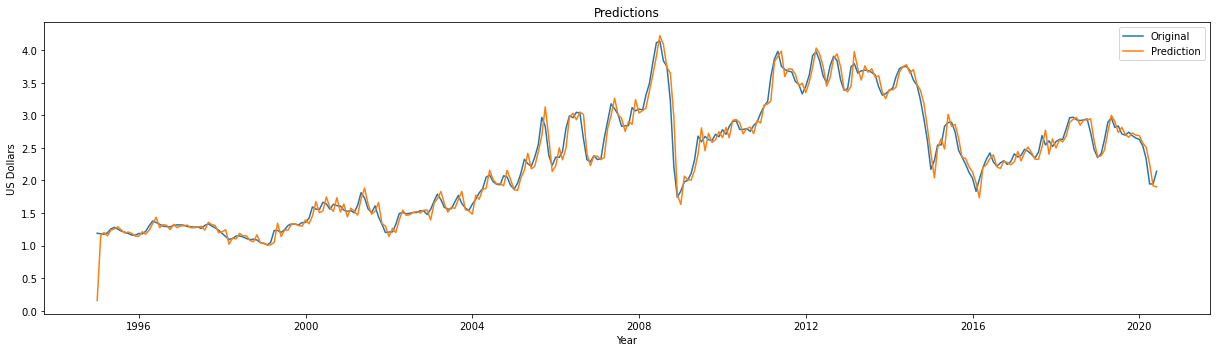

In [70]:
predictions_graph(train_yhat_ar_exg, train)

This graph looks good. Let's try to do all of this on the test variables and see what comes of it.

In [71]:
test.head()

,retail_gas_price
date,
2020-07-01,2.243
2020-08-01,2.245
2020-09-01,2.260
2020-10-01,2.228
2020-11-01,2.159


In [72]:
#getting the test predictions
test_yhat_ar_exg = ar_exg.predict(start = test.index[0],end = test.index[-1],typ='levels', exog = exog_test)

In [73]:
#RMSE Value
ar_exgtest_rmse = np.sqrt(mean_squared_error(test, test_yhat_ar_exg))
ar_exgtest_rmse

0.1591849650857843

The RMSE is not too far off from the train. That is a good sign.

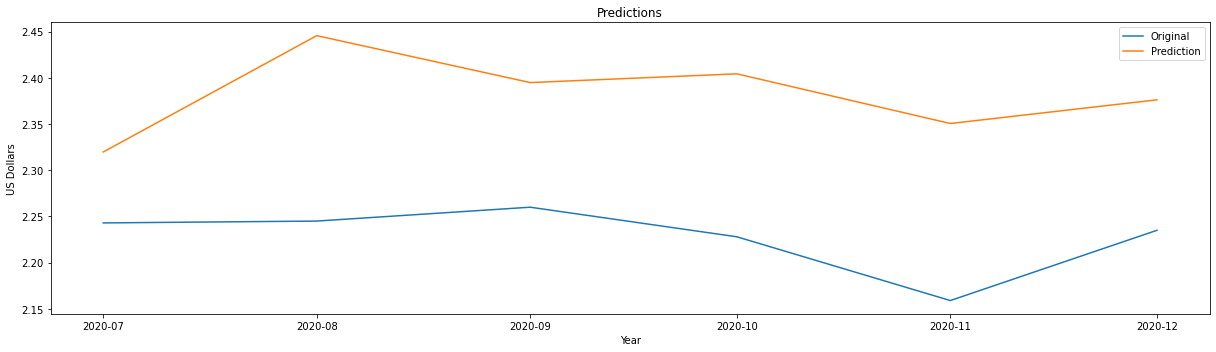

In [74]:
predictions_graph(test_yhat_ar_exg, test)

This is getting better. Because we suspected seasonality in the beginning perhaps a SARIMAX might be better.

## SARIMAX with Exogenous

In [75]:
#using auto arima to get out ideal parameters
auto_arima(y = train, x = exog_train, seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  306
Model:             SARIMAX(5, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 206.779
Date:                              Wed, 21 Apr 2021   AIC                           -391.558
Time:                                      14:08:37   BIC                           -350.634
Sample:                                           0   HQIC                          -375.189
                                              - 306                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1932      0.071     16.914      0.000       1.055       1.331
ar.L2          0.0766      0.102      0.748      0.454      -0.124       0.277
ar.L3         -1.0926      0.074    -14.760      0.000      -1.238      -0.948
ar.L4          0.6795      0.078      8.678      0.000       0.526       0.833
ar.L5         -0.3002      0.056     -5.399      0.000      -0.409      -0.191
ma.L1         -0.6716      0.048    -13.997      0.000      -0.766      -0.578
ma.L2         -0.7077      0.060    -11.756      0.000      -0.826      -0.590
ma.L3          0.9047      0.049     18.370      0.000       0.808       1.001
ar.S.L12       0.0426      0.360      0.118      0.906      -0.662       0.747
ma.S.L12      -0.2104      0.362     -0.581      0.561      -0.919       0.499
sigma2         0.0150      0.001     15.146      0.000       0.013       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               183.56
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               4.95   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It seems our parameters are the same as before. Let's proceed with them.

In [76]:
#creating a SARIMAX model with exogenous variables
sr_exg =SARIMAX(endog = train, exog = exog_train,
                  order=(5, 1, 3),
                  seasonal_order=(1, 0, 1, 12),
                  enforce_stationarity=False,
        
                  enforce_invertibility=False).fit()

train_yhat_sr_exg = sr_exg.predict(typ='levels')
train_yhat_sr_exg[:5]

1995-01-01    0.156717
1995-02-01    1.626420
1995-03-01    1.161461
1995-04-01    1.292943
1995-05-01    1.185911
Freq: MS, Name: predicted_mean, dtype: float64

In [77]:
sr_exg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     retail_gas_price   No. Observations:                  306
Model:             SARIMAX(5, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 165.305
Date:                              Wed, 21 Apr 2021   AIC                           -286.609
Time:                                      14:08:39   BIC                           -206.024
Sample:                                  01-01-1995   HQIC                          -254.316
                                       - 06-01-2020                                         
Covariance Type:                                opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
oil_supply                6.187e-07   8.94e-07      0.692      0.489   -1.13e-06    2.37e-06
crude_oil_production     -8.036e-05   2.31e-05     -3.472      0.001      -0.000    -3.5e-05
employees_oil_extraction     0.0066      0.009      0.760      0.447      -0.010       0.023
imports                     -0.0437      0.070     -0.627      0.531      -0.180       0.093
federal_gas_tax              0.0185      0.018      1.010      0.313      -0.017       0.054
state_gas_tax               -0.0218      0.035     -0.624      0.533      -0.090       0.047
inflation                    0.0339      0.026      1.314      0.189      -0.017       0.084
GPR_MEXICO                  -0.0006      0.000     -1.881      0.060      -0.001    2.35e-05
GPR_RUSSIA               -4.894e-05      0.000     -0.181      0.856      -0.001       0.000
GPR_SAUDI_ARABIA             0.0005      0.000      1.895      0.058   -1.88e-05       0.001
GPR_COLOMBIA              6.859e-05      0.000      0.240      0.810      -0.000       0.001
ar.L1                        0.9151      0.817      1.120      0.263      -0.686       2.516
ar.L2                       -0.1373      1.133     -0.121      0.904      -2.358       2.083
ar.L3                        0.3895      0.960      0.406      0.685      -1.493       2.272
ar.L4                       -0.2068      0.484     -0.427      0.669      -1.156       0.743
ar.L5                        0.0109      0.175      0.062      0.951      -0.333       0.355
ma.L1                       -0.4031      0.747     -0.540      0.589      -1.867       1.061
ma.L2                       -0.3335      0.828     -0.403      0.687      -1.956       1.289
ma.L3                       -0.5471      0.757     -0.723      0.470      -2.030       0.936
ar.S.L12                     0.1854      0.754      0.246      0.806      -1.293       1.664
ma.S.L12                    -0.0942      0.764     -0.123      0.902      -1.591       1.403
sigma2                       0.0155      0.010      1.505      0.132      -0.005       0.036
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):                79.89
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               2.66   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
#RMSE Value
sr_exgtrain_rmse = np.sqrt(mean_squared_error(train, train_yhat_sr_exg))
sr_exgtrain_rmse

0.14719329954032015

This is surprisingly a little higher than the RMSE of the ARIMA with Exogenous above.

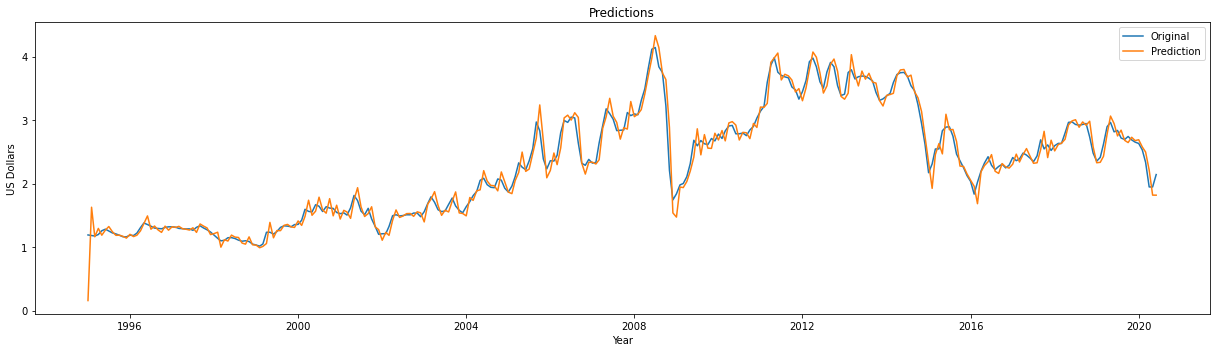

In [79]:
predictions_graph(train_yhat_sr_exg, train)

In [80]:
test.head()

,retail_gas_price
date,
2020-07-01,2.243
2020-08-01,2.245
2020-09-01,2.260
2020-10-01,2.228
2020-11-01,2.159


In [81]:
test_yhat_sr_exg = sr_exg.predict(start = test.index[0],end = test.index[-1], dynamic= False, exog = exog_test)

In [82]:
#RMSE Value
sr_exgtest_rmse = np.sqrt(mean_squared_error(test, test_yhat_sr_exg))
sr_exgtest_rmse

0.1756023729149813

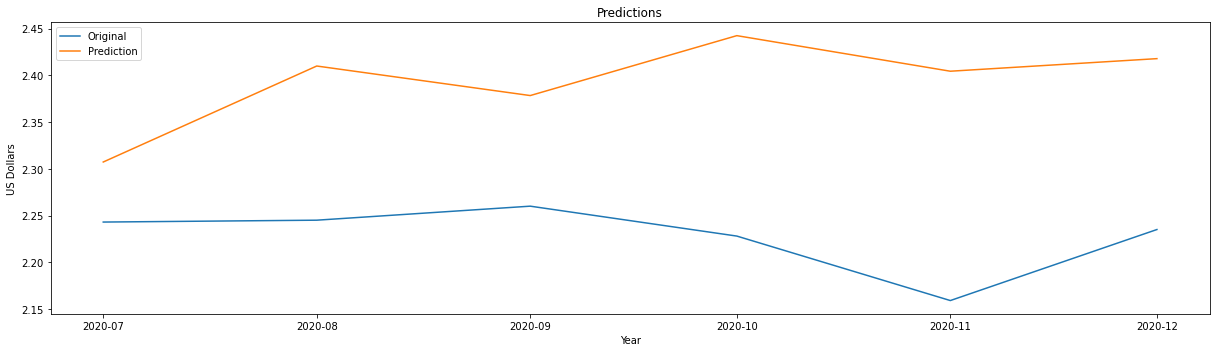

In [83]:
predictions_graph(test_yhat_sr_exg, test)

# Model Selection

In [86]:
rmse_results = pd.DataFrame({'Model': ['ARIMA', 'SARIMAX', 'FB PROPHET', 'ARIMA EXOG', 'SARIMAX EXOG'],
                            'Train_RMSE': [artrain_rmse, srtrain_rmse, fbtrain_rmse, ar_exgtrain_rmse, sr_exgtrain_rmse],
                            'Test_RMSE': [artest_rmse, srtest_rmse, fbtest_rmse, ar_exgtest_rmse, sr_exgtest_rmse]})
rmse_results

,Model,Train_RMSE,Test_RMSE
0,ARIMA,0.144499,0.210437
1,SARIMAX,0.147844,0.196624
2,FB PROPHET,0.365916,0.141446
3,ARIMA EXOG,0.138745,0.159185
4,SARIMAX EXOG,0.147193,0.175602


In [88]:
print(rmse_results[rmse_results.Test_RMSE == rmse_results.Test_RMSE.min()])

        Model  Train_RMSE  Test_RMSE
2  FB PROPHET    0.365916   0.141446


Utilizing the RMSE as our performance metric, we would have to choose the Facebook Prophet model. With the lowest RMSE score, we can be more confident in our predictions with this model. It was also the only model that did not overfit.

In [113]:
ts_for_fb

,ds,y
0,1995-01-01,1.190
1,1995-02-01,1.181
2,1995-03-01,1.173
3,1995-04-01,1.197
4,1995-05-01,1.256
5,1995-06-01,1.281
6,1995-07-01,1.252
7,1995-08-01,1.222
8,1995-09-01,1.206
9,1995-10-01,1.185


In [116]:
#Fitting the final model
ts_for_fb = ts.reset_index()
ts_for_fb.rename(columns = {'date':'ds', 'retail_gas_price':'y'}, inplace = True)
ts_for_fb.head()

final_model = Prophet()
final_model.fit(ts_for_fb)

#getting the predictions
future=final_model.make_future_dataframe(periods=12,freq='MS')
forecast=final_model.predict(future)
forecast[['ds', 'yhat']][-12:]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
312,2021-01-01,2.057189
313,2021-02-01,2.111994
314,2021-03-01,2.207844
315,2021-04-01,2.260065
316,2021-05-01,2.314176
317,2021-06-01,2.317410
318,2021-07-01,2.272633
319,2021-08-01,2.243652
320,2021-09-01,2.250692
321,2021-10-01,2.160796


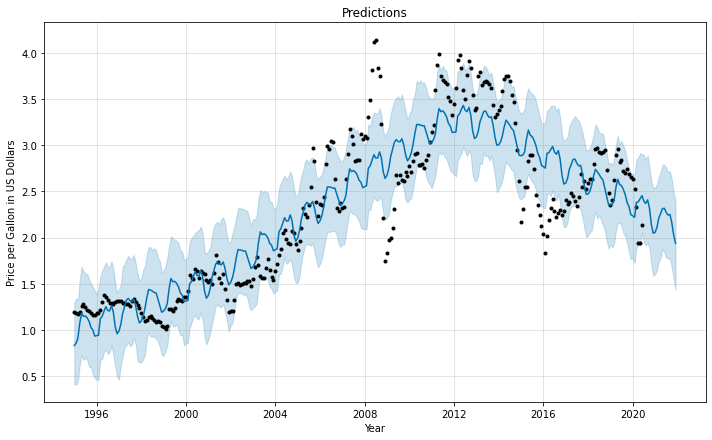

In [124]:
#plotting the forecast and its components
fig, ax = plt.subplots(figsize=(10,6))
prophet_model.plot(forecast, ax=ax)
ax.set_ylabel('Price per Gallon in US Dollars')
ax.set_xlabel('Year')
ax.set_title('Predictions');